<a href="https://colab.research.google.com/github/ramialnajdi/Customer-Lifetime-Value/blob/main/Costumer_lifetime_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Maximizing Business Growth: Predicting Customer Lifetime Value and Effective Segmentation**

**Introduction**

In today's competitive business environment, understanding and predicting customer behavior is crucial for strategic decision-making and long-term success. One of the most valuable metrics in this regard is the Customer Lifetime Value (CLV), which estimates the total revenue a business can expect from a single customer account throughout their relationship with the company. By accurately predicting CLV, businesses can tailor their marketing efforts, optimize customer service, and allocate resources more effectively to maximize profitability.

In this presentation, we will explore the methodology and outcomes of my recent analysis aimed at predicting customer lifetime value. Using advanced data analytics and statistical learning model, we have developed a predictive model to estimate CLV with high accuracy. Following the prediction phase, we conducted customer segmentation based on the predicted CLV scores to identify distinct customer groups with similar value characteristics.

This segmentation allows us to better understand our customer base, enabling targeted marketing strategies and personalized customer interactions. By focusing on the needs and behaviors of each segment, we can enhance customer satisfaction, increase retention rates, and ultimately drive higher revenue growth.



In [103]:
# Download the necessary libraries
!pip install ucimlrepo
!pip install lifetimes

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import summary_data_from_transaction_data
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

**Data Collection Overview**

To initiate our analysis, we embarked on a data collection phase aligned with our objectives. After thorough research, we identified the "Online Retail" dataset as highly suitable for our needs. This dataset is accessible at the following link: [Online Retail Dataset](https://archive.ics.uci.edu/dataset/352/online+retail.)

**Dataset Details:**

  * Nature: The dataset is transnational, encompassing all transactions recorded between December 1, 2010, and December 9, 2011.
  * Source: It pertains to a UK-based non-store online retail company.
  * Product Range: The company specializes in unique all-occasion gifts.
  * Customer Base: A significant portion of the company's customers are wholesalers.

This dataset provides a rich source of transactional data, essential for our analysis of Customer Lifetime Value (CLV) and customer segmentation.


In [105]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
df = online_retail.data.original

# display dataset
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


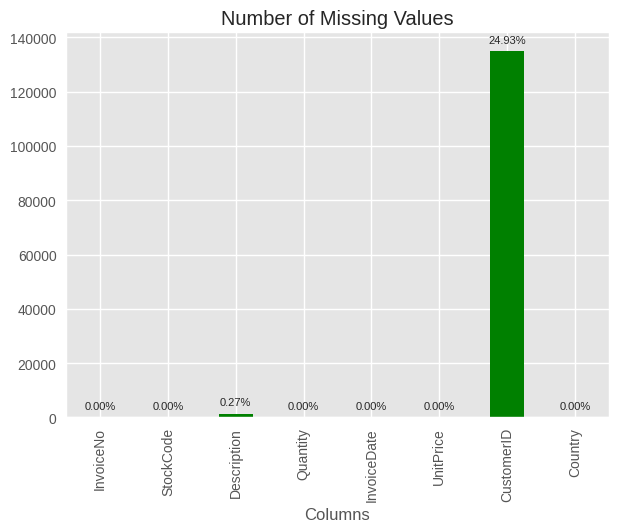

In [107]:
# display plot to show the number of null values in each colmun
ax = df.isnull().sum().plot(kind='bar', title="Number of Missing Values", figsize=(7, 5), color='green')

# Iterating over the bars one-by-one to show percentage of missing value in each bar
for bar in ax.patches:
    ax.annotate(f"{format((bar.get_height()/df.shape[0])*100, '.02f')}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=8,
                xytext=(0, 8),
                textcoords='offset points')

plt.xlabel('Columns')
plt.show()

* The DataFrame **df** contains 541,909 entries with 6 columns.
* **CustomerID** and **Description** column has missing values (NaN) for some entries which must be removed.


In [108]:
# Data preprocessing section
# convert InvoiceDate to date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# drop null customerID
df = df.dropna(subset=['CustomerID'])

# filter Quantity > 0
df = df[df['Quantity']>0]

# convert CustomerID to int
df['CustomerID'] = df['CustomerID'].astype(int)

# calculate Revenue (Revenue = Quantity * price)
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [109]:
print(f"Start Date: {df['InvoiceDate'].min()}")
print(f"End Date: {df['InvoiceDate'].max()}")
print(f"Total Revenue: {df['Revenue'].sum()}")
print(f"Total number of unique customers: {df['CustomerID'].nunique()}")
print(f"Total Quantities sold: {df['Quantity'].sum()}")

Start Date: 2010-12-01
End Date: 2011-12-09
Total Revenue: 8911407.904
Total number of unique customers: 4339
Total Quantities sold: 5181696


From December 1, 2010, to December 9, 2011, the business generated a total revenue of $8,911,407.90. During this period, 4,339 unique customers purchased a total of 5,181,696 units.

In [110]:
# Group by 'invoiceDate', calculate total revenue and unique customer count, rename columns
viz_df = df.groupby('InvoiceDate', as_index=False).agg({'Revenue': 'sum', 'CustomerID': 'nunique'})
viz_df.columns = ['InvoiceDate', 'TotalRevenue', 'CustomerCount']
viz_df['InvoiceDate'] = pd.to_datetime(viz_df['InvoiceDate'])

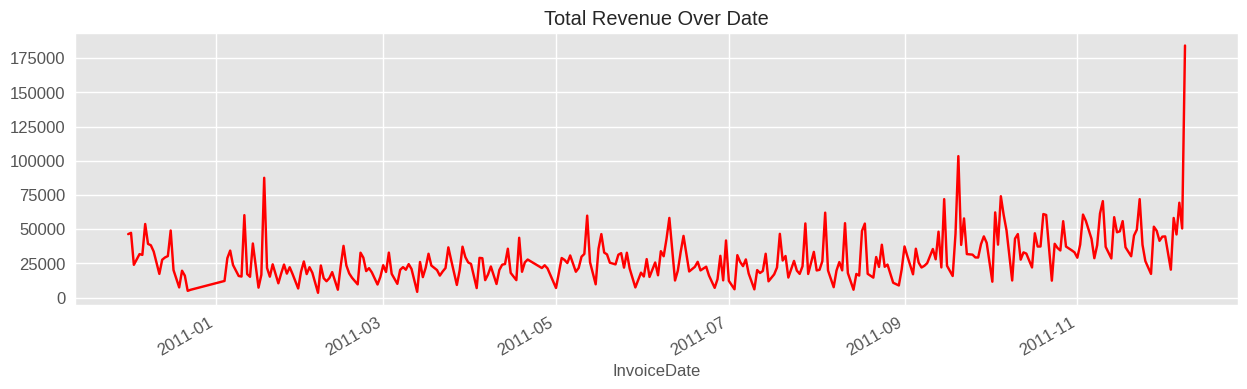

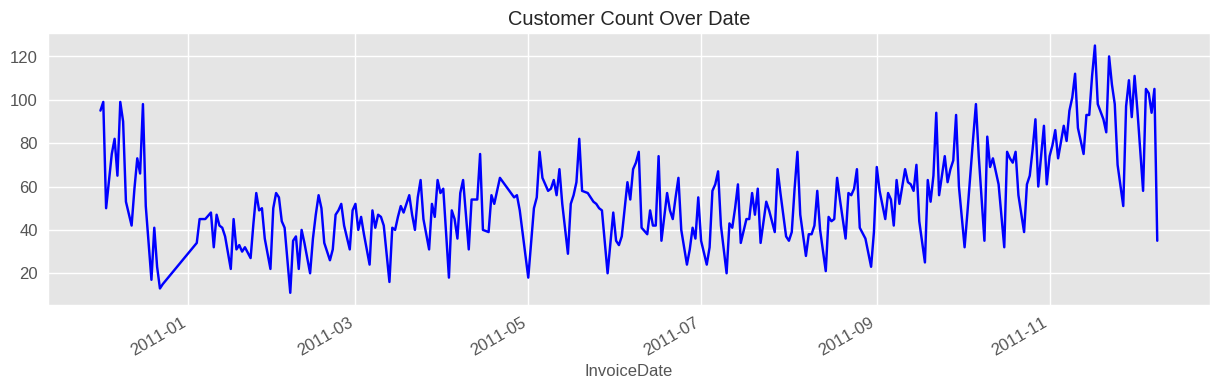

In [111]:
plt.style.use('ggplot')

viz_df.drop('CustomerCount', axis=1).set_index('InvoiceDate').plot(figsize=(15, 4), fontsize=12, color="red", legend=False)
plt.title('Total Revenue Over Date')

viz_df.drop('TotalRevenue', axis=1).set_index('InvoiceDate').plot(figsize=(15, 4), fontsize=12, color="blue", legend=False)
plt.title('Customer Count Over Date');

For the **Total Revenue Over Date** graph:
* The line graph shows daily total revenue from December 2010 to December 2011, with noticeable fluctuations throughout the year. Significant revenue spikes occur periodically, with the highest peak near the end of the period. Despite daily variability, revenue remains relatively stable over time. The largest spike suggests a major sales event or seasonal impact in December 2011. Overall, the graph highlights dynamic sales performance with intermittent peaks.


For the **Customer Count Over Date** graph:
* The line graph illustrates the daily customer count from December 2010 to December 2011. Initially, there are significant fluctuations, but from mid-2011, there is a general upward trend in the number of customers. Peaks occur intermittently, with the highest customer count reaching just over 120. The latter part of the period shows increased customer engagement, especially from September 2011 onwards. Overall, the graph indicates growing customer activity over time

In [112]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
data = summary_data_from_transaction_data(
    df, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue'
)

data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


Here is a quick explanation of the columns in the table above:

* **Frequency:** Represents the number of orders placed by a customer during the specified period, excluding the first order.

* **Recency:** Indicates the time duration between the first order and the last order placed by a customer during the specified period.

* **T:** Denotes the period (in days) from the customer’s first order to the end of the specified period.

* **Monetary Value:** Represents the average monetary value of all orders placed by each customer during the specified period. It should be noted that the probabilistic models assume a value of 0 for the first order.

**Fitting and testing the BG/NBD model.**

The first stage is to get a calibration period (train set) and
observation holdout period (test set).
As machine learning standards, the model will be fitted on the training set, and then the test set will be used to measure the performance of the model.

In [113]:
# detect train date and test date
cutoff_date = 210
total_duration = df['InvoiceDate'].max() - df['InvoiceDate'].min()
calibration_period_end = df['InvoiceDate'].min() + dt.timedelta(days=cutoff_date)
observation_period_end = calibration_period_end + (total_duration - dt.timedelta(days=cutoff_date))

print(f"Total Duration: {total_duration.days}")
print(f"End Train Period: {calibration_period_end}")
print(f"End Test Period: {observation_period_end}")

Total Duration: 373
End Train Period: 2011-06-29
End Test Period: 2011-12-09


The dataset contains 373 days of data, we will use 210 days to fit the model and 163 days to test the model.

In [114]:
# split the dataset into
df_cal_hold = calibration_and_holdout_data(transactions=df,
                                           customer_id_col="CustomerID",
                                           datetime_col="InvoiceDate",
                                           calibration_period_end=calibration_period_end,
                                           observation_period_end=observation_period_end)

In [115]:
df_cal_hold

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,162.0,0.0,163.0
12347,3.0,184.0,204.0,3.0,163.0
12348,2.0,110.0,195.0,1.0,163.0
12350,0.0,0.0,147.0,0.0,163.0
12352,3.0,34.0,133.0,3.0,163.0
...,...,...,...,...,...
18273,0.0,0.0,94.0,2.0,163.0
18280,0.0,0.0,114.0,0.0,163.0
18281,0.0,0.0,17.0,0.0,163.0


In [116]:
# fit model using train set (you can find more details in docs https://lifetimes.readthedocs.io/en/latest/Quickstart.html)
model = BetaGeoFitter(penalizer_coef=0.8)
model.fit(df_cal_hold['frequency_cal'], df_cal_hold['recency_cal'], df_cal_hold['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2954 subjects, a: 0.00, alpha: 23.51, b: 0.00, r: 0.29>

In [117]:
# Predicting the frequency for the holdout period for all customers.
pred_freq  = model.predict(df_cal_hold['duration_holdout'],
                           df_cal_hold['frequency_cal'],
                           df_cal_hold['recency_cal'],
                           df_cal_hold['T_cal'])

In [118]:
df_pred_freq = pd.DataFrame({'pred_frequency': pred_freq}).reset_index()
df_test = df_cal_hold.reset_index().merge(df_pred_freq, on='CustomerID').dropna()

In [119]:
print(f"""Error Score: {np.sqrt(
          mean_squared_error(
              df_test['frequency_holdout'],
              df_test['pred_frequency']
              )
          )
}""")

Error Score: 2.2092772278126467


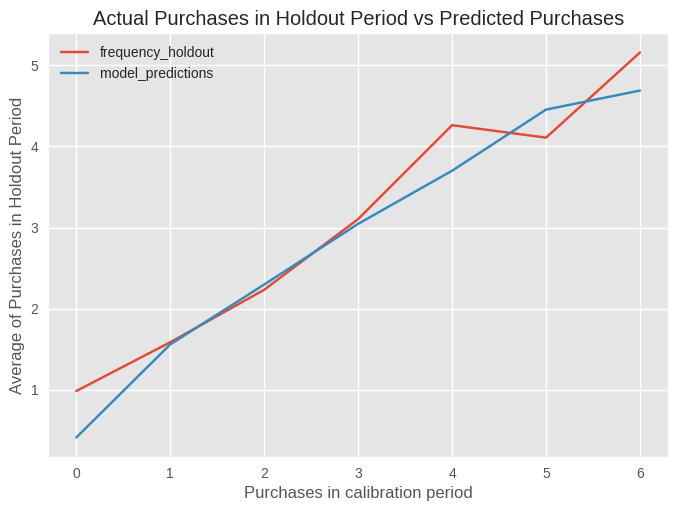

In [120]:
plot_calibration_purchases_vs_holdout_purchases(model, df_cal_hold);

The plot shows that the model's performance is quite good at predicting the frequencies in the holdout dataset.

In [121]:
# Predicting the number of purchases in the next t days for all customers
t = 163 # predict next five and half months
data['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(
    t,
    data['frequency'],
    data['recency'],
    data['T']
)

# drop null data
data = data.dropna()

# get the data where monetary value > 0
data = data[data['monetary_value']>0]

data.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342
12348,3.0,283.0,358.0,301.480000,1.406537
12352,6.0,260.0,296.0,368.256667,3.209963
12356,2.0,303.0,325.0,269.905000,1.072011
12358,1.0,149.0,150.0,683.200000,1.213804


In [122]:
# fit Gammma Gammma model (you can find more details in docs https://lifetimes.readthedocs.io/en/latest/Quickstart.html)
gg_model = GammaGammaFitter()
gg_model.fit(data['frequency'], data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [123]:
# predicting moetary value for each customer using Gamma Gamma model
data['pred_moetary'] = gg_model.conditional_expected_average_profit(
    data['frequency'],
    data['monetary_value']
)

data.head()

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary
CustomerID,,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342,569.988807
12348,3.0,283.0,358.0,301.480000,1.406537,333.762672
12352,6.0,260.0,296.0,368.256667,3.209963,376.166864
12356,2.0,303.0,325.0,269.905000,1.072011,324.008941
12358,1.0,149.0,150.0,683.200000,1.213804,539.930643


In [124]:
# predict customer lifetime value (CLV) using Gamma Gamma model
data['CLV'] = gg_model.customer_lifetime_value(
    model, # BetaGeoFitter model
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=5.5, # next five and half months
)

data

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary,CLV
CustomerID,,,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342,569.988807,1596.763016
12348,3.0,283.0,358.0,301.480000,1.406537,333.762672,500.739414
12352,6.0,260.0,296.0,368.256667,3.209963,376.166864,1287.962989
12356,2.0,303.0,325.0,269.905000,1.072011,324.008941,370.492253
12358,1.0,149.0,150.0,683.200000,1.213804,539.930643,699.051915
...,...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,3.200680,474.369525,1619.503339
18273,2.0,255.0,257.0,76.500000,1.331887,201.781295,286.662686
18282,1.0,119.0,126.0,77.840000,1.408655,260.275833,391.076030


After determining the anticipated customer lifetime value for each customer, the subsequent step involves categorizing our customers into distinct groups using unsupervised machine learning techniques like KMeans. However, prior to segmentation, we identified a significant outlier in the data that must be removed as it could negatively impact our results if left unaddressed.

In [125]:
data[data.index==16446]

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary,CLV
CustomerID,,,,,,,
16446,1.0,205.0,205.0,168469.6,0.921649,78051.285456,76730.559296


As we have seen this customer made only one purchase, but this purchase was highly profitable, generating a revenue of approximately 168,472.5. This indicates a significant outlier in terms of purchase value, highlighting the potential impact of individual high-value transactions on overall revenue.

In [126]:
# remove the outlier point
data = data.drop(index=16446)

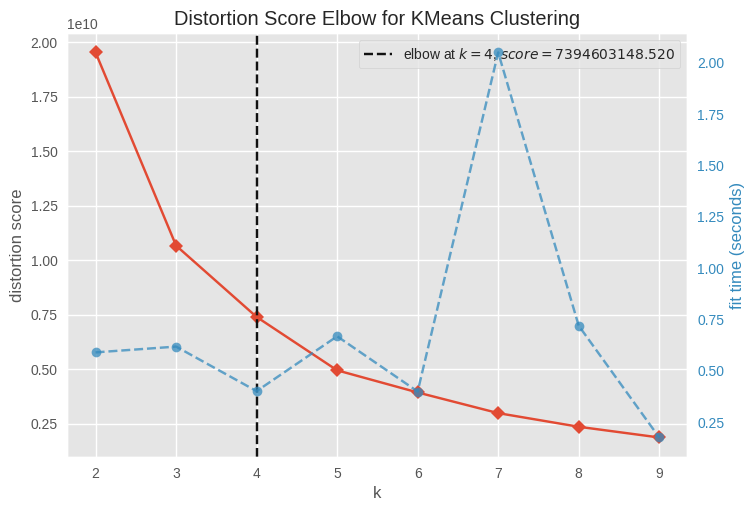

In [127]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

It's obvious that the optimal number of clusters is 4 as we heve seen from the elbow graph above.

In [128]:
# create KMeans model to segment row data into clusters
km_model = KMeans(n_clusters=4, random_state=42).fit(data)

# create a new column named "segments" that contains the cluster assigned to each point.
data['segments'] = km_model.labels_

In [129]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary,CLV,segments
CustomerID,,,,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342,569.988807,1596.763016,0
12348,3.0,283.0,358.0,301.480000,1.406537,333.762672,500.739414,0
12352,6.0,260.0,296.0,368.256667,3.209963,376.166864,1287.962989,0
12356,2.0,303.0,325.0,269.905000,1.072011,324.008941,370.492253,0
12358,1.0,149.0,150.0,683.200000,1.213804,539.930643,699.051915,0


In [130]:
df_segments = data.groupby(['segments'])['CLV'].agg(['mean', 'count']).reset_index()
df_segments.columns = ['segment', 'avg_CLV', 'n_customers']
df_segments['percentage of cluster'] = (df_segments['n_customers']/df_segments['n_customers'].sum())*100
df_segments

,segment,avg_CLV,n_customers,percentage of cluster
0,0,1086.751232,2753,98.709215
1,1,99427.206808,4,0.143421
2,2,17523.521387,28,1.003944
3,3,51378.069515,4,0.143421


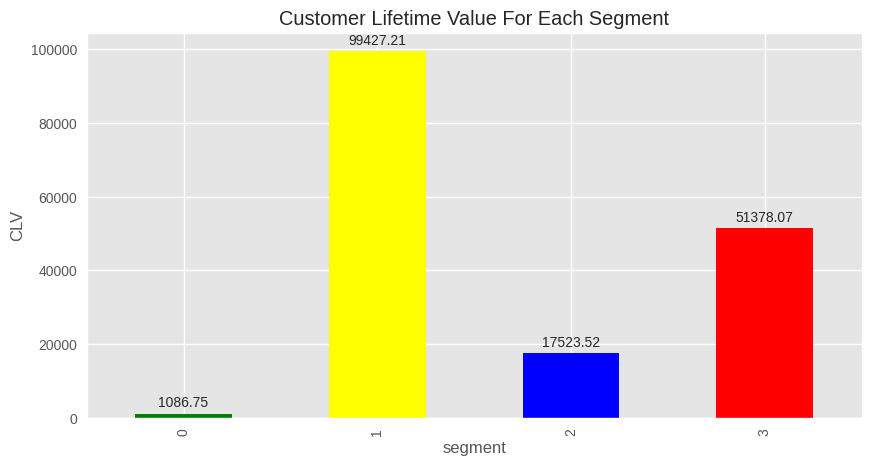

In [131]:
ax = df_segments.plot(kind='bar', x='segment', y='avg_CLV', color=['green', 'yellow', 'blue', 'red'], legend=False, figsize=(10, 5))

# Iterating over the bars one-by-one to show value of avg_CLV in each bar
for bar in ax.patches:
    ax.annotate(f"{format(bar.get_height(), '.02f')}",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=10,
                xytext=(0, 8),
                textcoords='offset points')

plt.title('Customer Lifetime Value For Each Segment')
plt.ylabel('CLV')
plt.show()

The graph above shows us customer segmentation based on average Customer Lifetime Value (CLV). Segment 0, comprising 98.71% of customers, has the lowest avg_CLV at 1086.75. Segment 1, although representing only 0.14% of customers, has the highest avg_CLV at 99427.21. Segment 2 contains about 1.01% of customers with an avg_CLV of 17523.52 . Segment 3, making up 0.14% of customers, has an avg_CLV of 51378.06.

In [132]:
# let's rename the segments into (first level - second level - third level - fourth level)
data['customer_category'] = data['segments'].replace(
    {
        0:"forth level",
        1:"first level",
        2:"third level",
        3:"second level"
        }
)

In [133]:
df_cate_clv = data.groupby('customer_category')['CLV'].agg('mean').to_frame()
df_cate_clv['contribution_to_CLV'] = round((df_cate_clv/np.sum(df_cate_clv))*100, 2)

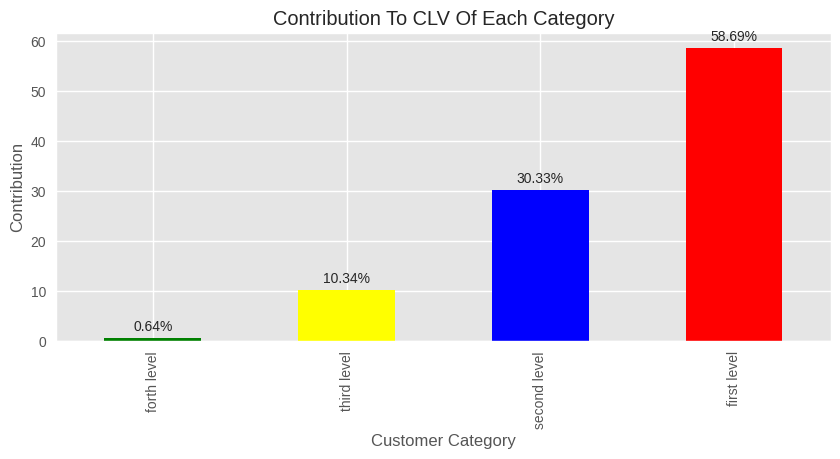

In [134]:
ax = (df_cate_clv.sort_values(by='contribution_to_CLV')
                 .plot(kind='bar',
                       y='contribution_to_CLV',
                       legend=False,
                       figsize=(10, 4),
                       color=['green', 'yellow', 'blue', 'red']))

# Iterating over the bars one-by-one to show the contribution to CLV of each category
for bar in ax.patches:
    ax.annotate(f"{format(bar.get_height(), '.02f')}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=10,
                xytext=(0, 8),
                textcoords='offset points')

plt.title('Contribution To CLV Of Each Category')
plt.ylabel('Contribution')
plt.xlabel('Customer Category')
plt.show()

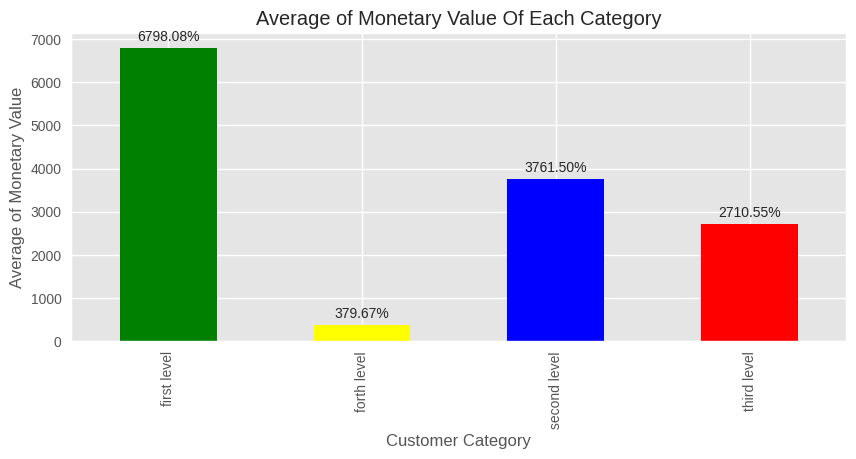

In [135]:
ax = (data.groupby('customer_category')['monetary_value'].agg('mean')
                                                         .plot(kind='bar',
                                                               color=['green', 'yellow', 'blue', 'red'],
                                                               figsize=(10, 4),
                                                               legend=False))


# Iterating over the bars one-by-one to show the contribution to CLV of each category
for bar in ax.patches:
    ax.annotate(f"{format(bar.get_height(), '.02f')}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=10,
                xytext=(0, 8),
                textcoords='offset points')

plt.title('Average of Monetary Value Of Each Category')
plt.ylabel('Average of Monetary Value')
plt.xlabel('Customer Category')
plt.show()

In [136]:
# apple dimensional reduction on dataset
from sklearn.decomposition import PCA
features = data.drop(['segments', 'customer_category'], axis=1)
pca = PCA(n_components=2).fit(features)
reduction_data = pca.transform(features)

pd.DataFrame({'explained_variance_ratio1':pca.explained_variance_ratio_[0],
              'explained_variance_ratio2':pca.explained_variance_ratio_[1],
              'completed_explained_variance': np.sum(pca.explained_variance_ratio_)
              },
             index=['Values']).T

,Values
explained_variance_ratio1,0.982189
explained_variance_ratio2,0.016545
completed_explained_variance,0.998734


The table indicates the explained variance ratios for a dataset. The first component accounts for 74.45% of the variance. The second component explains 25.47% of the variance. Combined, these two components explain 99.91% of the total variance in the data.

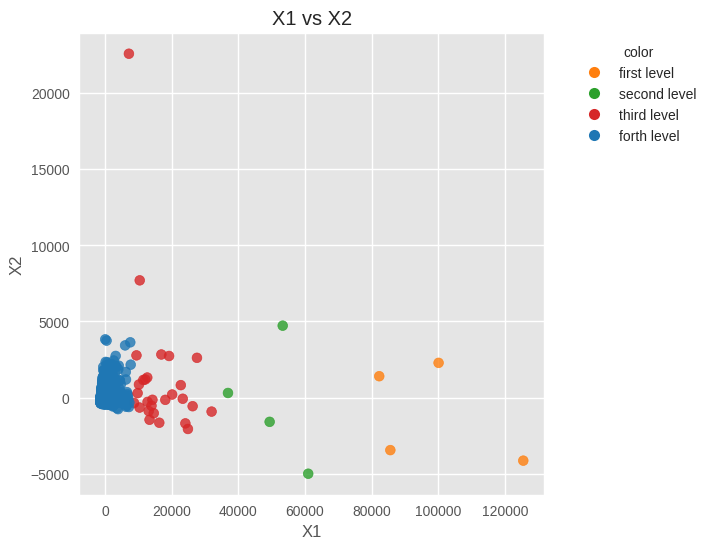

In [137]:
fig, ax = plt.subplots(figsize=(6, 6))

colors = {"first level":'tab:orange',
          "second level":'tab:green',
          "third level":'tab:red',
          "forth level":'tab:blue'}

ax.scatter(reduction_data[:, 0], reduction_data[:, 1], c=data['customer_category'].map(colors), alpha=.8)

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('X1 vs X2')
plt.show()

The graph visualizes a 2D projection of the dataset using PCA dimensional reduction. It shows data points categorized into four levels: first, second, third, and forth, represented by different colors. The x-axis (X1) and y-axis (X2) represent the principal components.

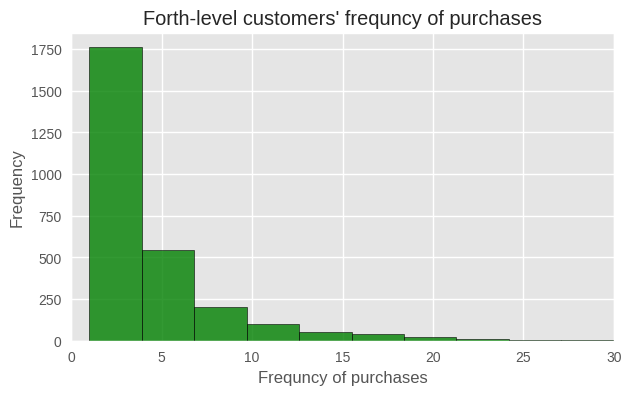

In [138]:
data[data['customer_category']=='forth level']['frequency'].plot(kind='hist',
                                                                 bins=30,
                                                                 xlim=(0, 30),
                                                                 color='green',
                                                                 edgecolor='black',
                                                                 figsize=(7, 4),
                                                                 alpha=0.8)

plt.xlabel('Frequncy of purchases')
plt.title("Forth-level customers' frequncy of purchases")
plt.show()

**Forth-Level Customers' Purchase Frequency Report**

The histogram chart above indicates the frequency of purchases made by customers classified under the "forth level" category. Most of these customers made fewer than 5 purchases, with the highest frequency observed for those making 1-2 purchases. The distribution then rapidly declines, showing significantly fewer customers making higher numbers of purchases, with very few exceeding 10 purchases. This suggests that forth level customers typically have low engagement in terms of purchase frequency.

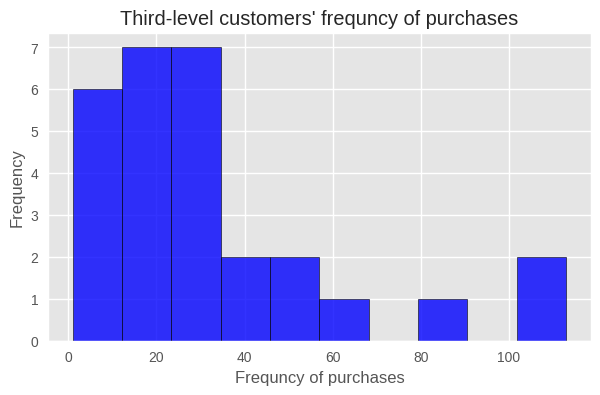

In [139]:
data[data['customer_category']=='third level']['frequency'].plot(kind='hist',
                                                                 color='blue',
                                                                 edgecolor='black',
                                                                 figsize=(7, 4),
                                                                 alpha=0.8)

plt.xlabel('Frequncy of purchases')
plt.title("Third-level customers' frequncy of purchases")
plt.show()

**Third-Level Customers' Purchase Frequency Report**

The histogram depicts the purchase frequency of third-level customers. The majority of these customers made around 20 to 30 purchases, with the highest frequency in the 15-35 purchase range. There are some outliers, with a few customers making up to 100 purchases. This distribution suggests that third-level customers tend to be more engaged, making significantly more purchases compared to the forth level customers.

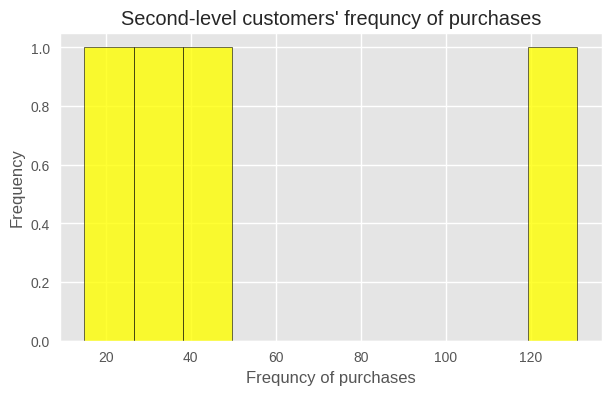

In [140]:
data[data['customer_category']=='second level']['frequency'].plot(kind='hist',
                                                                 color='yellow',
                                                                 edgecolor='black',
                                                                 figsize=(7, 4),
                                                                 alpha=0.8)

plt.xlabel('Frequncy of purchases')
plt.title("Second-level customers' frequncy of purchases")
plt.show()

**Second-Level Customers' Purchase Frequency Report**

The histogram shows the purchase frequency distribution for second-level customers. The data reveals three distinct frequency groups: around 20, 40, and 120 purchases, each with a frequency of 1. This indicates that second-level customers exhibit diverse purchasing behaviors, with peaks at these specific purchase counts. The uniform height of the bars suggests that these purchase frequencies are equally common among second-level customers.

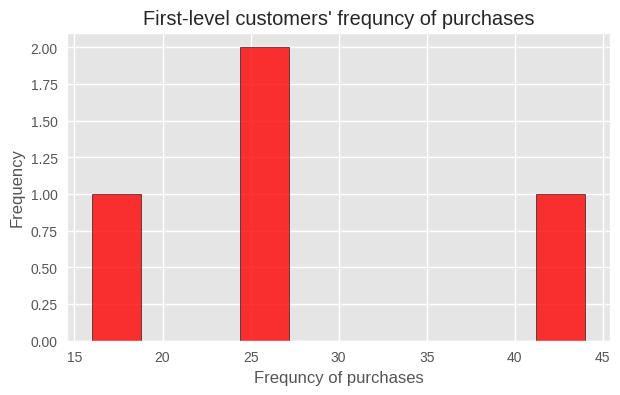

In [141]:
data[data['customer_category']=='first level']['frequency'].plot(kind='hist',
                                                                 color='red',
                                                                 edgecolor='black',
                                                                 figsize=(7, 4),
                                                                 alpha=0.8)

plt.xlabel('Frequncy of purchases')
plt.title("First-level customers' frequncy of purchases")
plt.show()

**First-Level Customers' Purchase Frequency Report**

The histogram illustrates the purchase frequency for first-level customers, showing three distinct peaks. The most common purchase frequency is around 25, with a frequency of 2. There are also notable purchase frequencies around 20 and 40, each with a frequency of 1. This distribution suggests that first-level customers generally make between 15 to 45 purchases, with a preference for around 25 purchases

**Customer Segmentation Analysis Report**

* **Introduction**

After conducting data clustering on our customer data, we identified four distinct customer segments. The presence of outliers in the data poses a challenge, as removing them could compromise our analysis and exclude important customers. Since KMeans, our chosen clustering algorithm, is particularly sensitive to outliers, their impact must be carefully considered.

The table below summarizes the segmentation results:

| Segment | Average CLV     | Number of Customers | Percentage of Cluster (%) |
|---------|------------------|---------------------|---------------------------|
| 0       | 1086.75          | 2753                | 98.71                     |
| 1       | 99427.21         | 4                   | 0.14                      |
| 2       | 17523.52         | 28                  | 1.00                      |
| 3       | 51378.07         | 4                   | 0.14                      |

**Observations**

* **Segment Imbalance:** Segments 1, 2, and 3 together constitute only 1.28% of the total customer base. This significant imbalance suggests that the majority of our customers fall into Segment 0.

* **Impact of Outliers:** The outliers likely contribute to this imbalance, influencing the clustering results.

**Recommendations**
To address the imbalance and gain deeper insights, we propose further segmentation within Segment 0. By applying the KMeans algorithm specifically to the customers in Segment 0, we aim to achieve a more granular understanding of this dominant segment.

**Next Steps**
* **Re-segmentation of Segment 0:** Conduct a detailed clustering analysis on Segment 0 to identify sub-segments.

* **Analysis of Sub-segments:** Evaluate the characteristics and behaviors of these sub-segments to inform targeted strategie


**note:**  segment 0 = forth level - segment 1 = first level - segment 2 = third level - segment 3 = second level

In [142]:
forth_level_customer_df = data[data['customer_category']=='forth level']
forth_level_customer_df.drop(['segments', 'customer_category'], axis=1, inplace=True)

In [143]:
forth_level_customer_df

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary,CLV
CustomerID,,,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342,569.988807,1596.763016
12348,3.0,283.0,358.0,301.480000,1.406537,333.762672,500.739414
12352,6.0,260.0,296.0,368.256667,3.209963,376.166864,1287.962989
12356,2.0,303.0,325.0,269.905000,1.072011,324.008941,370.492253
12358,1.0,149.0,150.0,683.200000,1.213804,539.930643,699.051915
...,...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,3.200680,474.369525,1619.503339
18273,2.0,255.0,257.0,76.500000,1.331887,201.781295,286.662686
18282,1.0,119.0,126.0,77.840000,1.408655,260.275833,391.076030


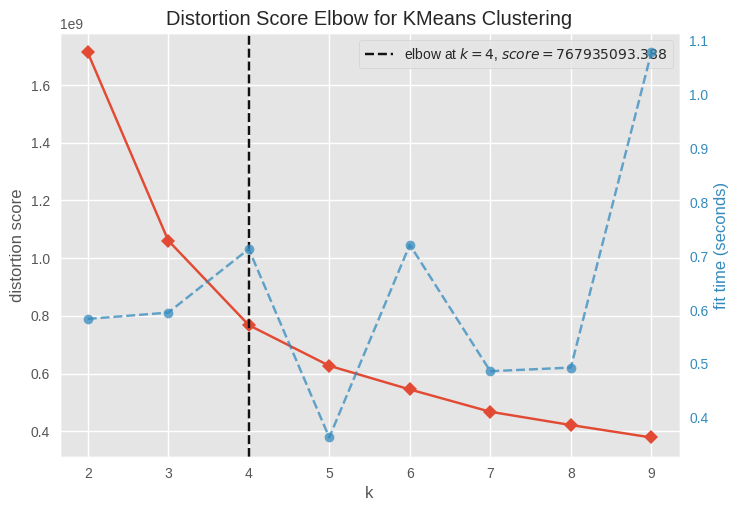

In [144]:
# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(forth_level_customer_df)        # Fit the data to the visualizer
visualizer.show();

In [145]:
km_model = KMeans(n_clusters=4, random_state=42).fit(forth_level_customer_df)
forth_level_customer_df['segment'] = km_model.labels_
forth_level_customer_df

,frequency,recency,T,monetary_value,predicted_purchases,pred_moetary,CLV,segment
CustomerID,,,,,,,,
12347,6.0,365.0,367.0,599.701667,2.626342,569.988807,1596.763016,3
12348,3.0,283.0,358.0,301.480000,1.406537,333.762672,500.739414,0
12352,6.0,260.0,296.0,368.256667,3.209963,376.166864,1287.962989,3
12356,2.0,303.0,325.0,269.905000,1.072011,324.008941,370.492253,0
12358,1.0,149.0,150.0,683.200000,1.213804,539.930643,699.051915,0
...,...,...,...,...,...,...,...,...
18272,5.0,244.0,246.0,487.752000,3.200680,474.369525,1619.503339,3
18273,2.0,255.0,257.0,76.500000,1.331887,201.781295,286.662686,0
18282,1.0,119.0,126.0,77.840000,1.408655,260.275833,391.076030,0


In [146]:
forth_level_customer_segments = forth_level_customer_df.groupby('segment')['CLV'].agg(['mean', 'count'])
forth_level_customer_segments['average of frequency'] = forth_level_customer_df.groupby('segment')['frequency'].agg('mean')
forth_level_customer_segments = forth_level_customer_segments.sort_values(by='mean', ascending=False)
forth_level_customer_segments.index = ['forth level', 'fifth level', 'sixth level', 'seventh level']
forth_level_customer_segments = forth_level_customer_segments.reset_index()
forth_level_customer_segments.columns = ['customer category', 'average of CLV',	'number of customers', 'average of frequency']
forth_level_customer_segments['percentage of cluster'] = forth_level_customer_segments['number of customers']/forth_level_customer_segments['number of customers'].sum()*100
forth_level_customer_segments

,customer category,average of CLV,number of customers,average of frequency,percentage of cluster
0,forth level,6277.369923,57,16.719298,2.070469
1,fifth level,3094.586393,245,9.938776,8.899382
2,sixth level,1394.887332,747,5.097724,27.134036
3,seventh level,489.355371,1704,2.340376,61.896113


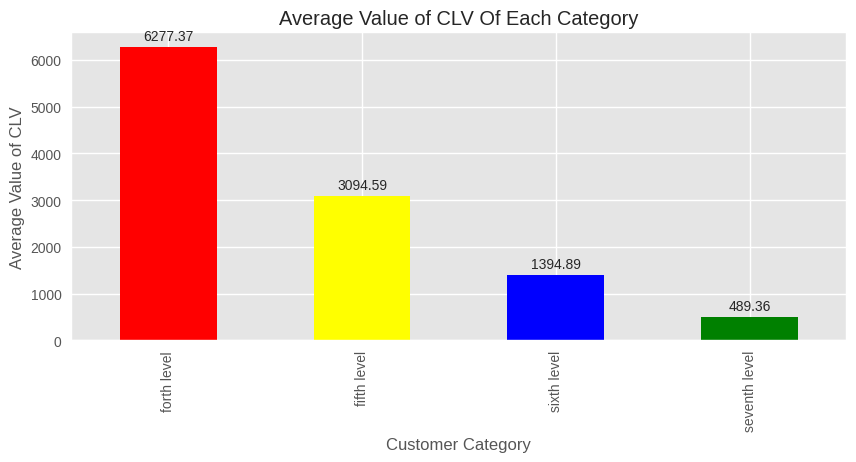

In [147]:
ax = forth_level_customer_segments.plot(kind='bar',
                                       x='customer category',
                                       y='average of CLV',
                                       figsize=(10, 4),
                                       color=['red', 'yellow', 'blue', 'green'],
                                       legend=False)

# Iterating over the bars one-by-one to show the contribution to CLV of each category
for bar in ax.patches:
    ax.annotate(f"{format(bar.get_height(), '.02f')}",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center',
                va='center',
                size=10,
                xytext=(0, 8),
                textcoords='offset points')

plt.title('Average Value of CLV Of Each Category')
plt.ylabel('Average Value of CLV')
plt.xlabel('Customer Category')
plt.show()

The bar graph illustrates the average Customer Lifetime Value (CLV) across four customer categories. The fourth level has the highest average CLV at 6277.37, significantly outperforming other categories. The fifth level follows with an average CLV of 3094.59, while the sixth level has an average CLV of 1394.89. The seventh level exhibits the lowest average CLV, at 489.36. This disparity highlights the varying value contributions of different customer segments, with the fourth level being particularly valuable.

In [148]:
first_part_customer_segment = data.groupby('customer_category')[['CLV', 'frequency']].agg(['mean', 'count'])
first_part_customer_segment = first_part_customer_segment.reset_index()
first_part_customer_segment.columns = first_part_customer_segment.columns.droplevel()
first_part_customer_segment.columns = ['customer category', 'average of CLV', 'number of customers', 'average of frequency', '##']
first_part_customer_segment = first_part_customer_segment.drop('##', axis=1)
first_part_customer_segment = first_part_customer_segment.sort_values(by='average of CLV', ascending=False).reset_index(drop=True)
first_part_customer_segment['percentage of cluster'] = first_part_customer_segment['number of customers']/first_part_customer_segment['number of customers'].sum()
first_part_customer_segment = first_part_customer_segment.drop(index=3)

In [149]:
first_part_customer_segment

,customer category,average of CLV,number of customers,average of frequency,percentage of cluster
0,first level,99427.206808,4,27.750000,0.001434
1,second level,51378.069515,4,53.750000,0.001434
2,third level,17523.521387,28,32.714286,0.010039


In [150]:
customer_segments = pd.concat([first_part_customer_segment, forth_level_customer_segments], axis=0)
customer_segments

,customer category,average of CLV,number of customers,average of frequency,percentage of cluster
0,first level,99427.206808,4,27.750000,0.001434
1,second level,51378.069515,4,53.750000,0.001434
2,third level,17523.521387,28,32.714286,0.010039
0,forth level,6277.369923,57,16.719298,2.070469
1,fifth level,3094.586393,245,9.938776,8.899382
2,sixth level,1394.887332,747,5.097724,27.134036
3,seventh level,489.355371,1704,2.340376,61.896113


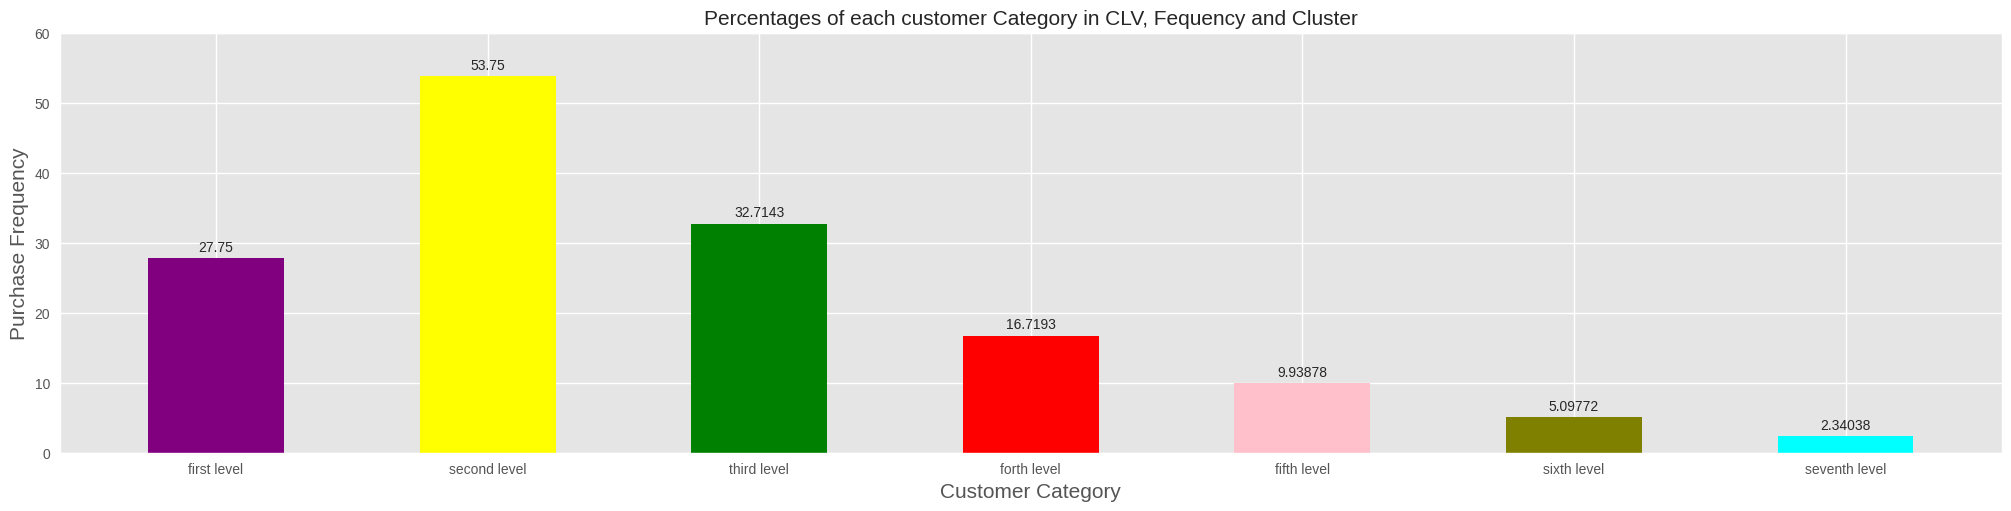

In [151]:
fig, ax = plt.subplots(layout='constrained', figsize=(20, 5))

x = customer_segments['customer category']
values = ax.bar(x, height=customer_segments['average of frequency'], width=0.5, color=['purple', 'yellow', 'green', 'red', 'pink', 'olive', 'cyan'])
ax.bar_label(values, padding=3)

ax.set_ylabel('Purchase Frequency', fontsize=15)
ax.set_xlabel('Customer Category', fontsize=15)
ax.set_title('Percentages of each customer Category in CLV, Fequency and Cluster', fontsize=15)
ax.set_ylim(0, 60)
plt.show()

**Customer Purchase Frequency Analysis**

The graph illustrates the purchase frequency distribution across seven customer levels. The second level exhibits the highest purchase frequency at 53.75%, indicating frequent and consistent purchasing behavior. The third level follows with 32.71%, while the first level has a moderate frequency of 27.75%. The fourth and fifth levels show significantly lower frequencies at 16.72% and 9.94%, respectively. The sixth and seventh levels have the lowest frequencies at 5.10% and 2.34%, suggesting infrequent purchases among these customers. This analysis highlights the varied purchasing behaviors across different customer segments.

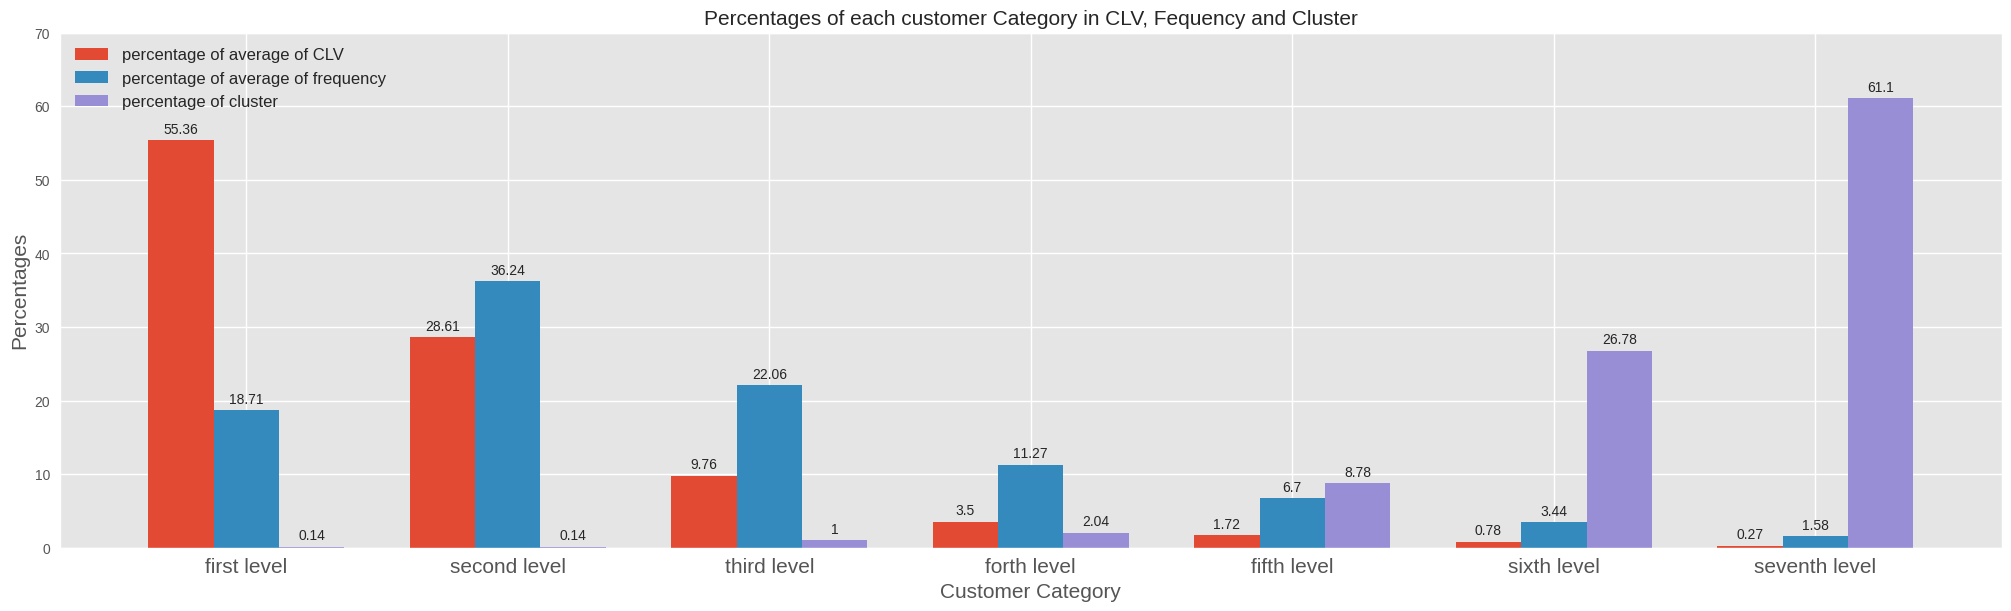

In [152]:
import matplotlib.pyplot as plt
import numpy as np

type_of_customer = customer_segments['customer category']

x = np.arange(customer_segments.shape[0])  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(20, 6))

columns = ['average of CLV',	'average of frequency',	'number of customers']
labels = ['percentage of average of CLV', 'percentage of average of frequency', 'percentage of cluster']
for column, label in zip(columns, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, round(customer_segments[column]/customer_segments[column].sum()*100, 2), width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentages', fontsize=15)
ax.set_xlabel('Customer Category', fontsize=15)
ax.set_title('Percentages of each customer Category in CLV, Fequency and Cluster', fontsize=15)
ax.set_xticks(x + width, type_of_customer, fontsize=15)
ax.legend(fontsize=12)
ax.set_ylim(0, 70)

plt.show()

**Customer Segmentation Analysis Report**

**Visual Representation**

The above chart illustrates the percentages of average CLV, purchase frequency, and cluster representation across the seven customer levels.

**Overview**

* The following report provides a comprehensive analysis of customer segmentation based on transaction data. The segmentation is aimed at understanding customer behavior and value through metrics like Customer Lifetime Value (CLV), purchase frequency, and clustering percentages. This analysis helps in identifying key customer groups and tailoring marketing strategies accordingly.

**Segmentation Results**
* The segmentation identified seven distinct customer levels, each characterized by different percentages of average CLV, purchase frequency, and cluster representation.

**Key Findings**

1. **First Level**

    * **Percentage of Average CLV:** 55.36%
    * **Percentage of Average Purchase Frequency:** 18.71%
    * **Percentage of Cluster Representation:** 0.14%
    * **Insights:** This highly valuable segment significantly contributes to our revenue despite its small size. These customers demonstrate strong loyalty and significant spending.

2. **Second Level**

    * **Percentage of Average CLV:** 28.61%
    * **Percentage of Average Purchase Frequency:** 36.24%
    * **Percentage of Cluster Representation:** 0.14%
    * **Insights:** These customers balance moderate CLV with high purchase frequency, indicating consistent and repeat purchasing behavior.

3. **Third Level**

    * **Percentage of Average CLV:** 9.76%
    * **Percentage of Average Purchase Frequency:** 22.06%
    * **Percentage of Cluster Representation:** 1%
    * **Insights:** This segment has moderate CLV and purchase frequency. With a higher cluster representation, it provides a stable customer base with growth potential.

4. **Fourth Level**

    * **Percentage of Average CLV:** 3.5%
    * **Percentage of Average Purchase Frequency:** 11.27%
    * **Percentage of Cluster Representation:** 2.04%
    * **Insights:** Customers in this segment contribute less to revenue but represent a notable portion of our customer base, indicating potential for value enhancement through targeted campaigns.

5. **Fifth Level**

    * **Percentage of Average CLV:** 1.72%
    * **Percentage of Average Purchase Frequency:** 6.7%
    * **Percentage of Cluster Representation:** 8.78%
    * **Insights:** This segment consists of low-value customers who still form a significant part of our customer base, suggesting opportunities for engagement improvement.

6. **Sixth Level**

    * **Percentage of Average CLV:** 0.78%
    * **Percentage of Average Purchase Frequency:** 3.44%
    * **Percentage of Cluster Representation:** 26.78%
    * **Insights:** A significant segment with very low CLV and frequency, indicating many low-engagement customers.

7. **Seventh Level**

    * **Percentage of Average CLV:** 0.27%
    * **Percentage of Average Purchase Frequency:** 1.58%
    * **Percentage of Cluster Representation:** 61.1%
    * **Insights:** The largest segment by cluster representation, but with the lowest CLV and frequency, highlighting many low-value customers.

**Recommendations**
* **Focus on High-Value Segments:** Prioritize marketing and engagement efforts on first and second-level customers due to their high CLV.
Enhance Mid-Value Segments: Develop strategies to increase the value and engagement of third and fourth-level customers.

* **Optimize Low-Value Segments:** Implement cost-effective methods to maintain the fifth to seventh-level customers or explore ways to convert them into higher-value segments.

**Conclusion**

This segmentation analysis provides actionable insights into our customer base, enabling us to tailor our marketing and engagement strategies effectively. By focusing on high-value segments and optimizing lower-value ones, we can enhance customer satisfaction and maximize revenue.
